In [221]:
# Load libraries
import numpy as np 
import pandas as pd 
import sys
import os


import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
import plotly.tools as tls
py.init_notebook_mode()

from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings('ignore')

from pandas import set_option
from tabulate import tabulate

In [222]:
class CFG:
    SEED = 2023
    imgdim1 = 20
    imgdim2 = 10

plt.style.use('fivethirtyeight')
plt.rcParams.update({'figure.figsize': (CFG.imgdim1, CFG.imgdim2)})

In [223]:
data = pd.read_csv("brest_cancer_data.csv")

In [224]:
for i in data.columns.to_list():
    print(i)
    print(data[i].nunique())
    print("=================================")

id
569
diagnosis
2
radius_mean
456
texture_mean
479
perimeter_mean
522
area_mean
539
smoothness_mean
474
compactness_mean
537
concavity_mean
537
concave points_mean
542
symmetry_mean
432
fractal_dimension_mean
499
radius_se
540
texture_se
519
perimeter_se
533
area_se
528
smoothness_se
547
compactness_se
541
concavity_se
533
concave points_se
507
symmetry_se
498
fractal_dimension_se
545
radius_worst
457
texture_worst
511
perimeter_worst
514
area_worst
544
smoothness_worst
411
compactness_worst
529
concavity_worst
539
concave points_worst
492
symmetry_worst
500
fractal_dimension_worst
535
Unnamed: 32
0


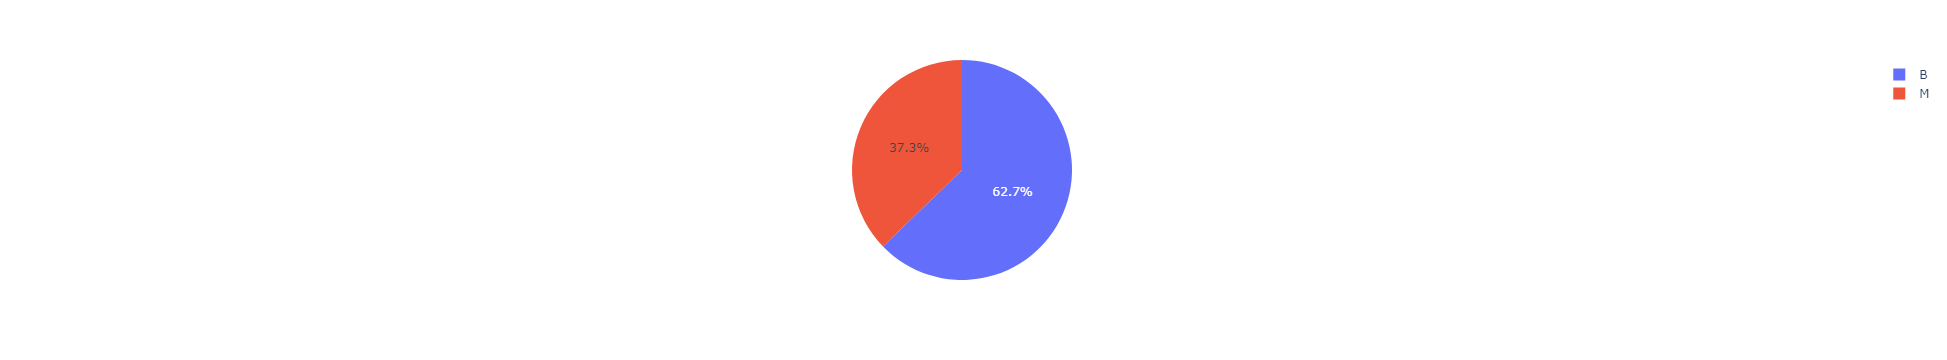

In [225]:
import plotly.express as px
fig = px.pie(data, names='diagnosis')
fig.show()

In [226]:
data.diagnosis.value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

In [227]:
data.drop("Unnamed: 32", axis = "columns", inplace = True)

In [228]:
data.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_worst  \
0  ...         25.38          17.33           184.60      2019.0   
1  ...         24.99          23.41           158.80      1956.0   
2  ...         23.57          25.53           152.50      1709.0   
3  ...         14.91          26.50            98.87       567.7   
4  ...         22.54          16.67           152.20      1575.0   

   smoothness_worst  compactness_worst  concavity_worst  concave points_worst  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   
3            0.2098             0.8663           0.6869                0.2575   
4            0.1374             0.2050           0.4000                0.1625   

   symmetry_worst  fractal_dimension_worst  
0          0.4601                  0.11890  
1          0.2750                  0.08902  
2          0.3613                  0.08758  
3          0.6638                  0.17300  
4          0.2364                  0.07678  

[5 rows x 32 columns]

In [229]:
data.describe().T.style.background_gradient(cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True))

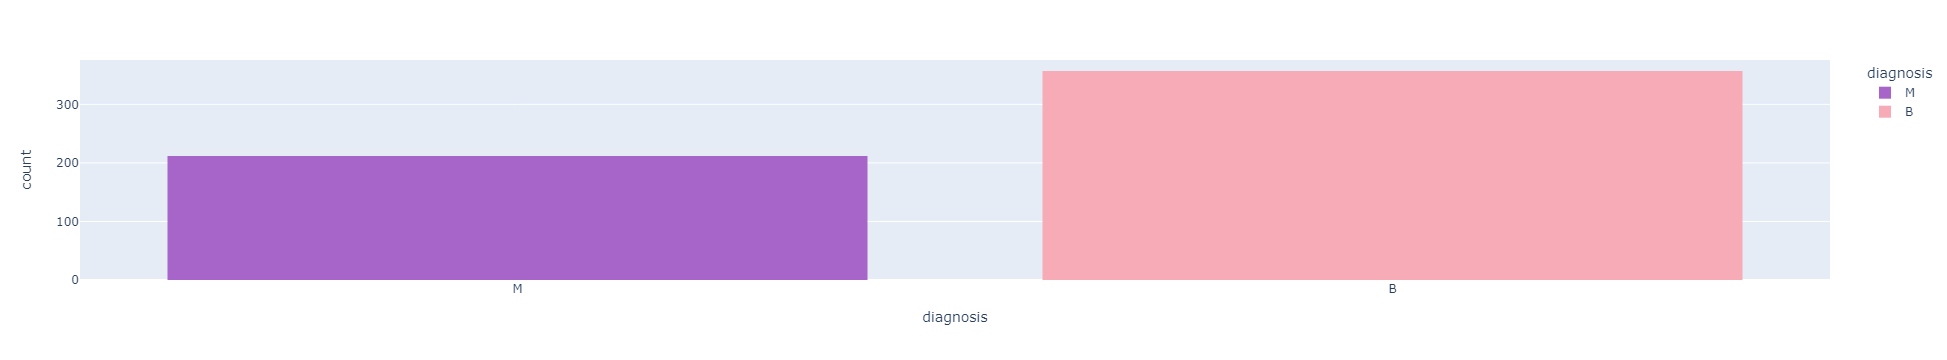

In [230]:
px.histogram(data_frame=data, x='diagnosis', color='diagnosis',color_discrete_sequence=['#A865C9','#f6abb6'])

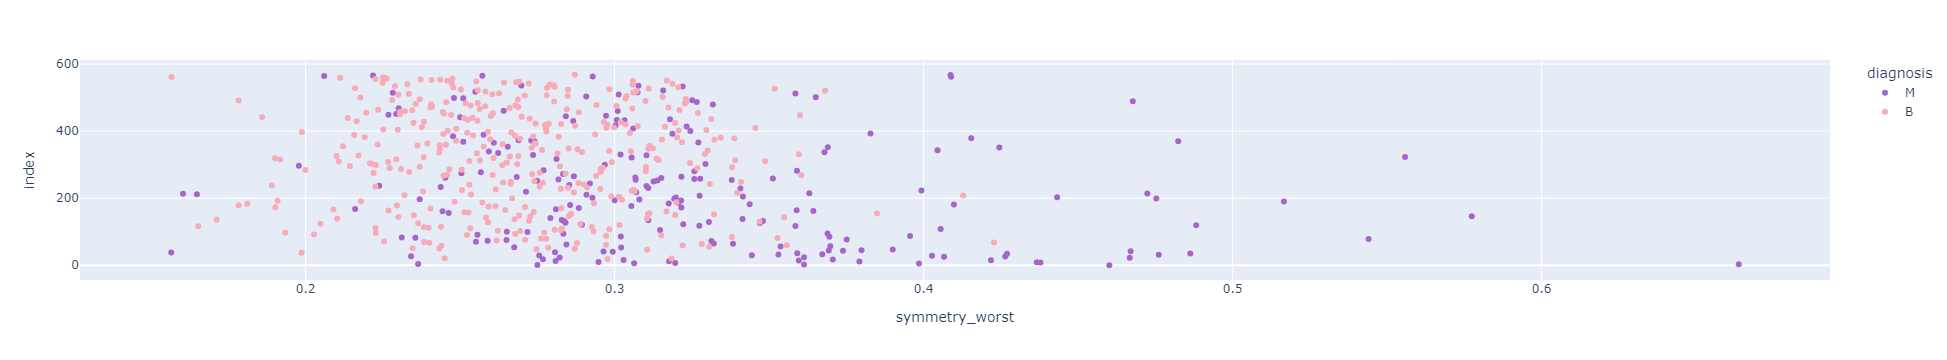

In [231]:
px.scatter(data_frame=data,x='symmetry_worst',color='diagnosis',color_discrete_sequence=['#A865C9','#f6abb6'])

In [232]:
data.drop('id', axis=1, inplace=True) 

In [233]:
data['diagnosis'] = (data['diagnosis'] == 'M').astype(int) #encode the label into 1/0

In [234]:
corr = data.corr()

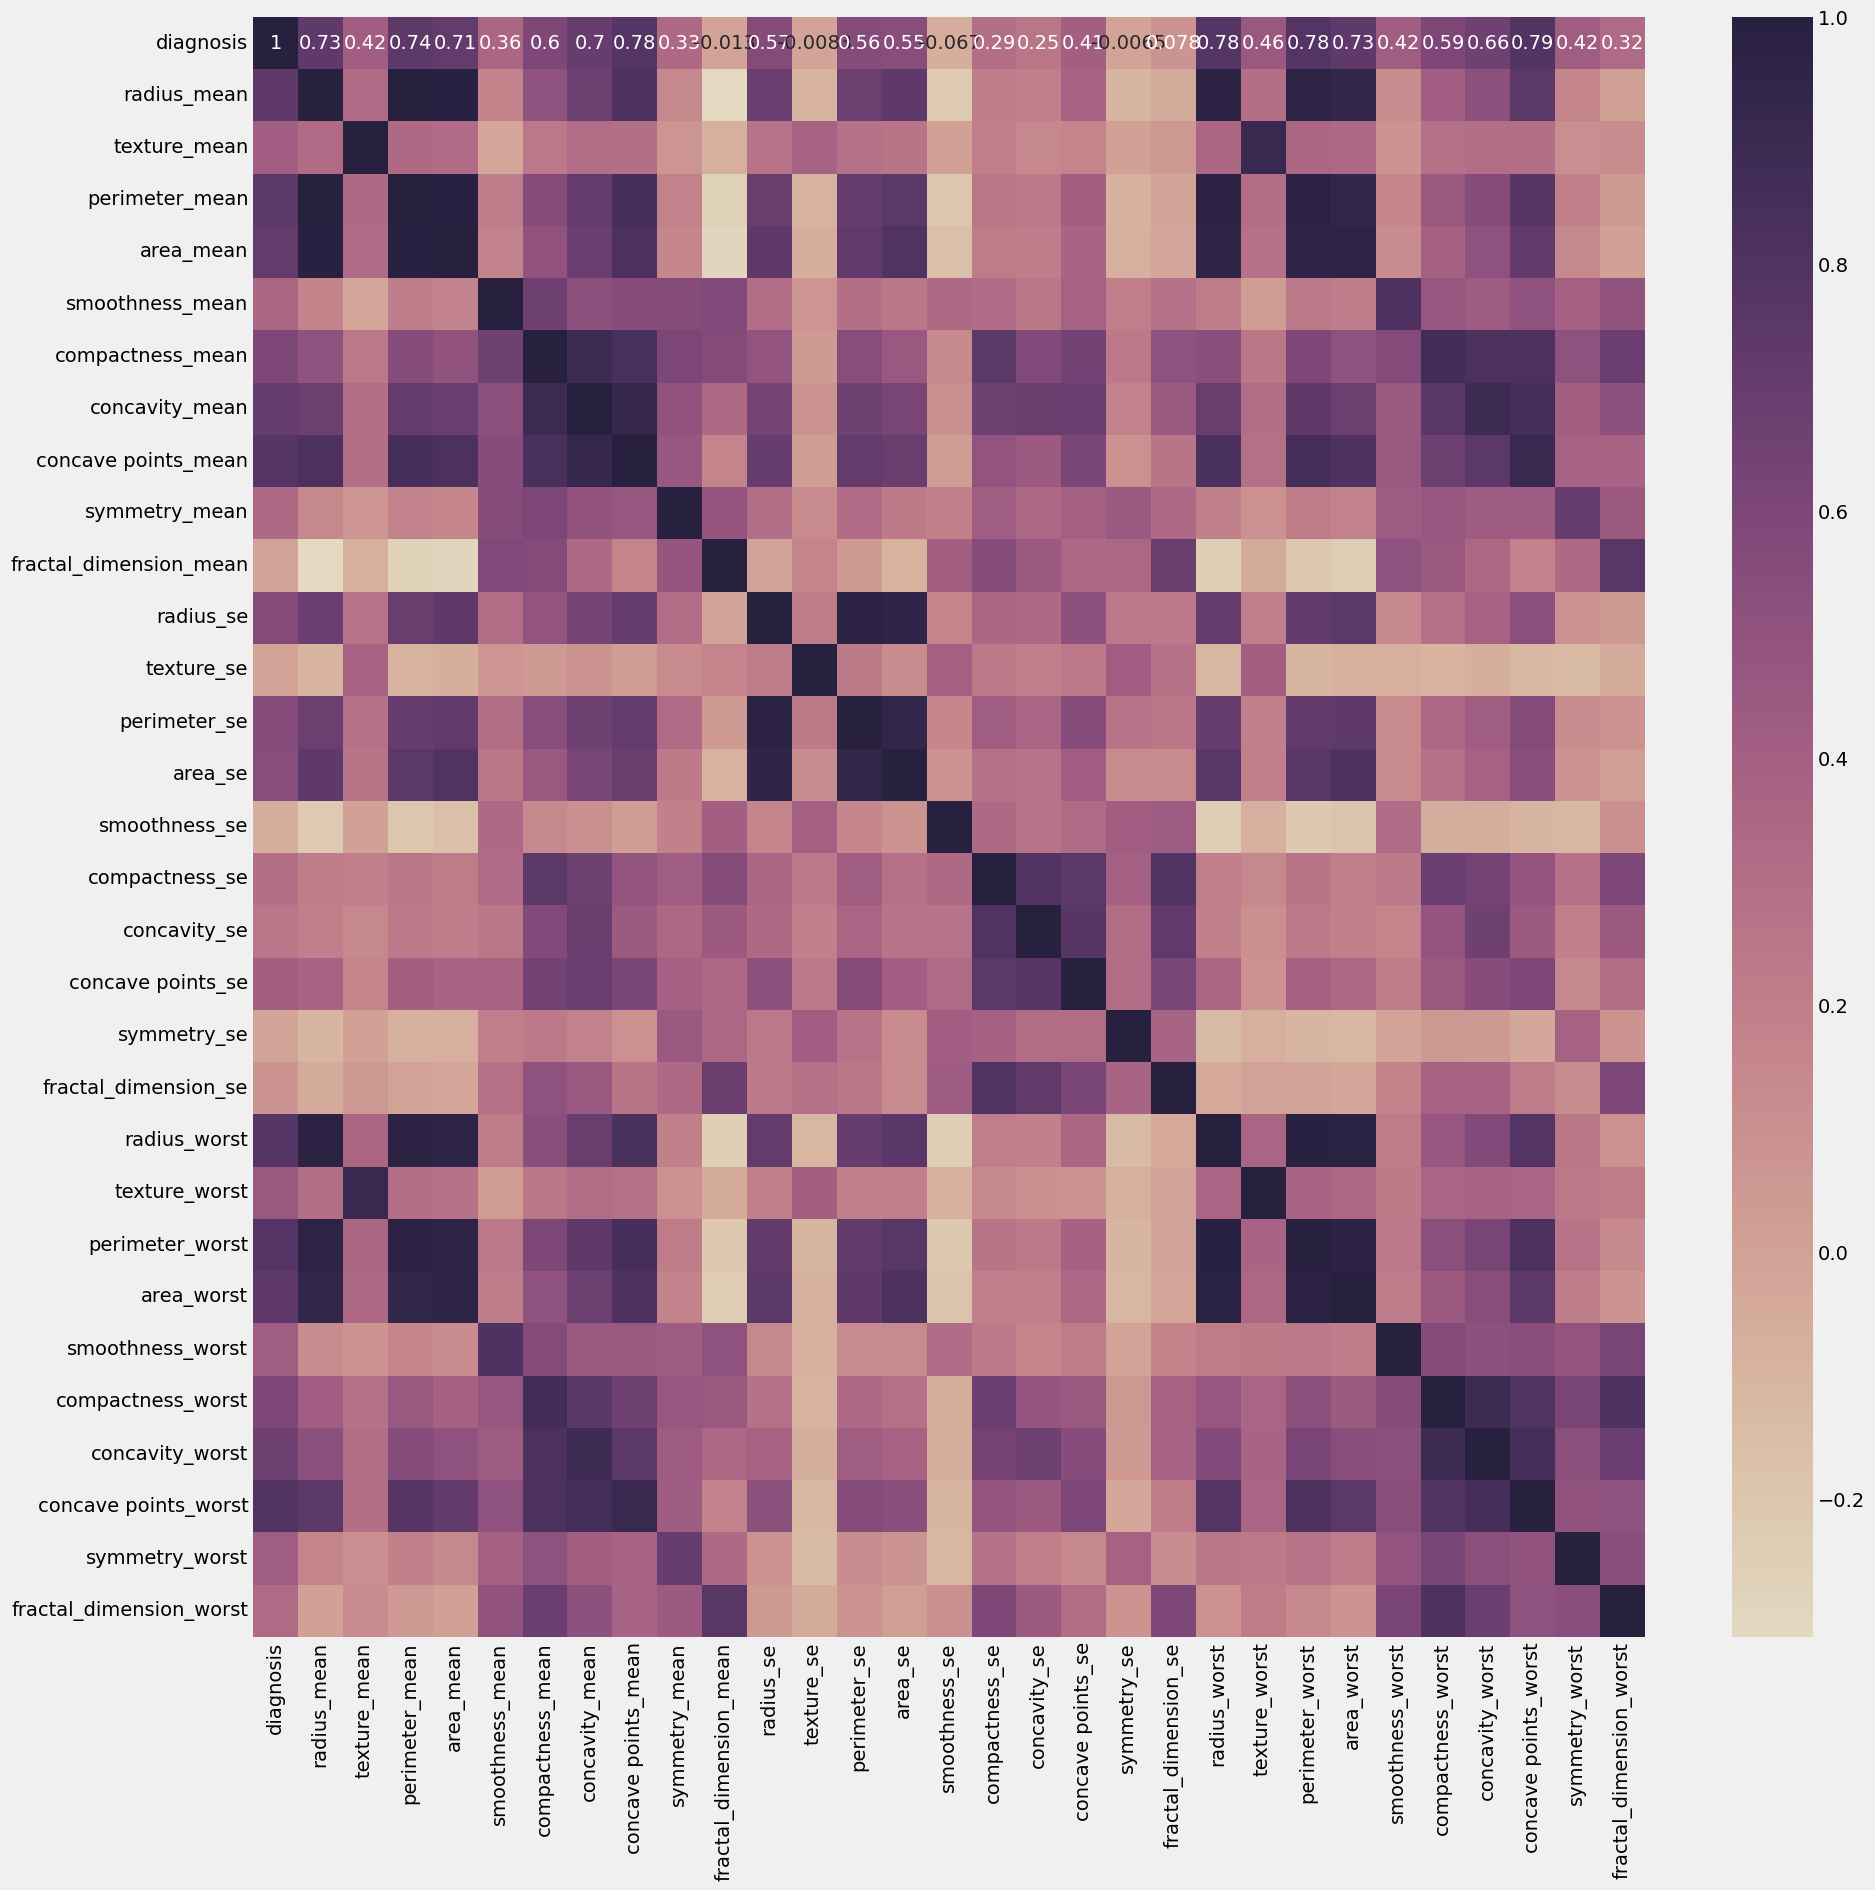

In [235]:
plt.figure(figsize=(20,20))
sns.heatmap(corr, cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True),annot=True)
plt.show()

# Get the absolute value of the correlation
cor_target = abs(corr["diagnosis"])

# Select highly correlated features (thresold = 0.2)
relevant_features = cor_target[cor_target>0.2]

# Collect the names of the features
names = [index for index, value in enumerate(relevant_features)]

In [236]:
train_col = data.columns.to_list()
train_col.remove("diagnosis")

In [237]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [238]:
for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = label_encoder.fit_transform(data[column])

                                     Features Distribution                                      


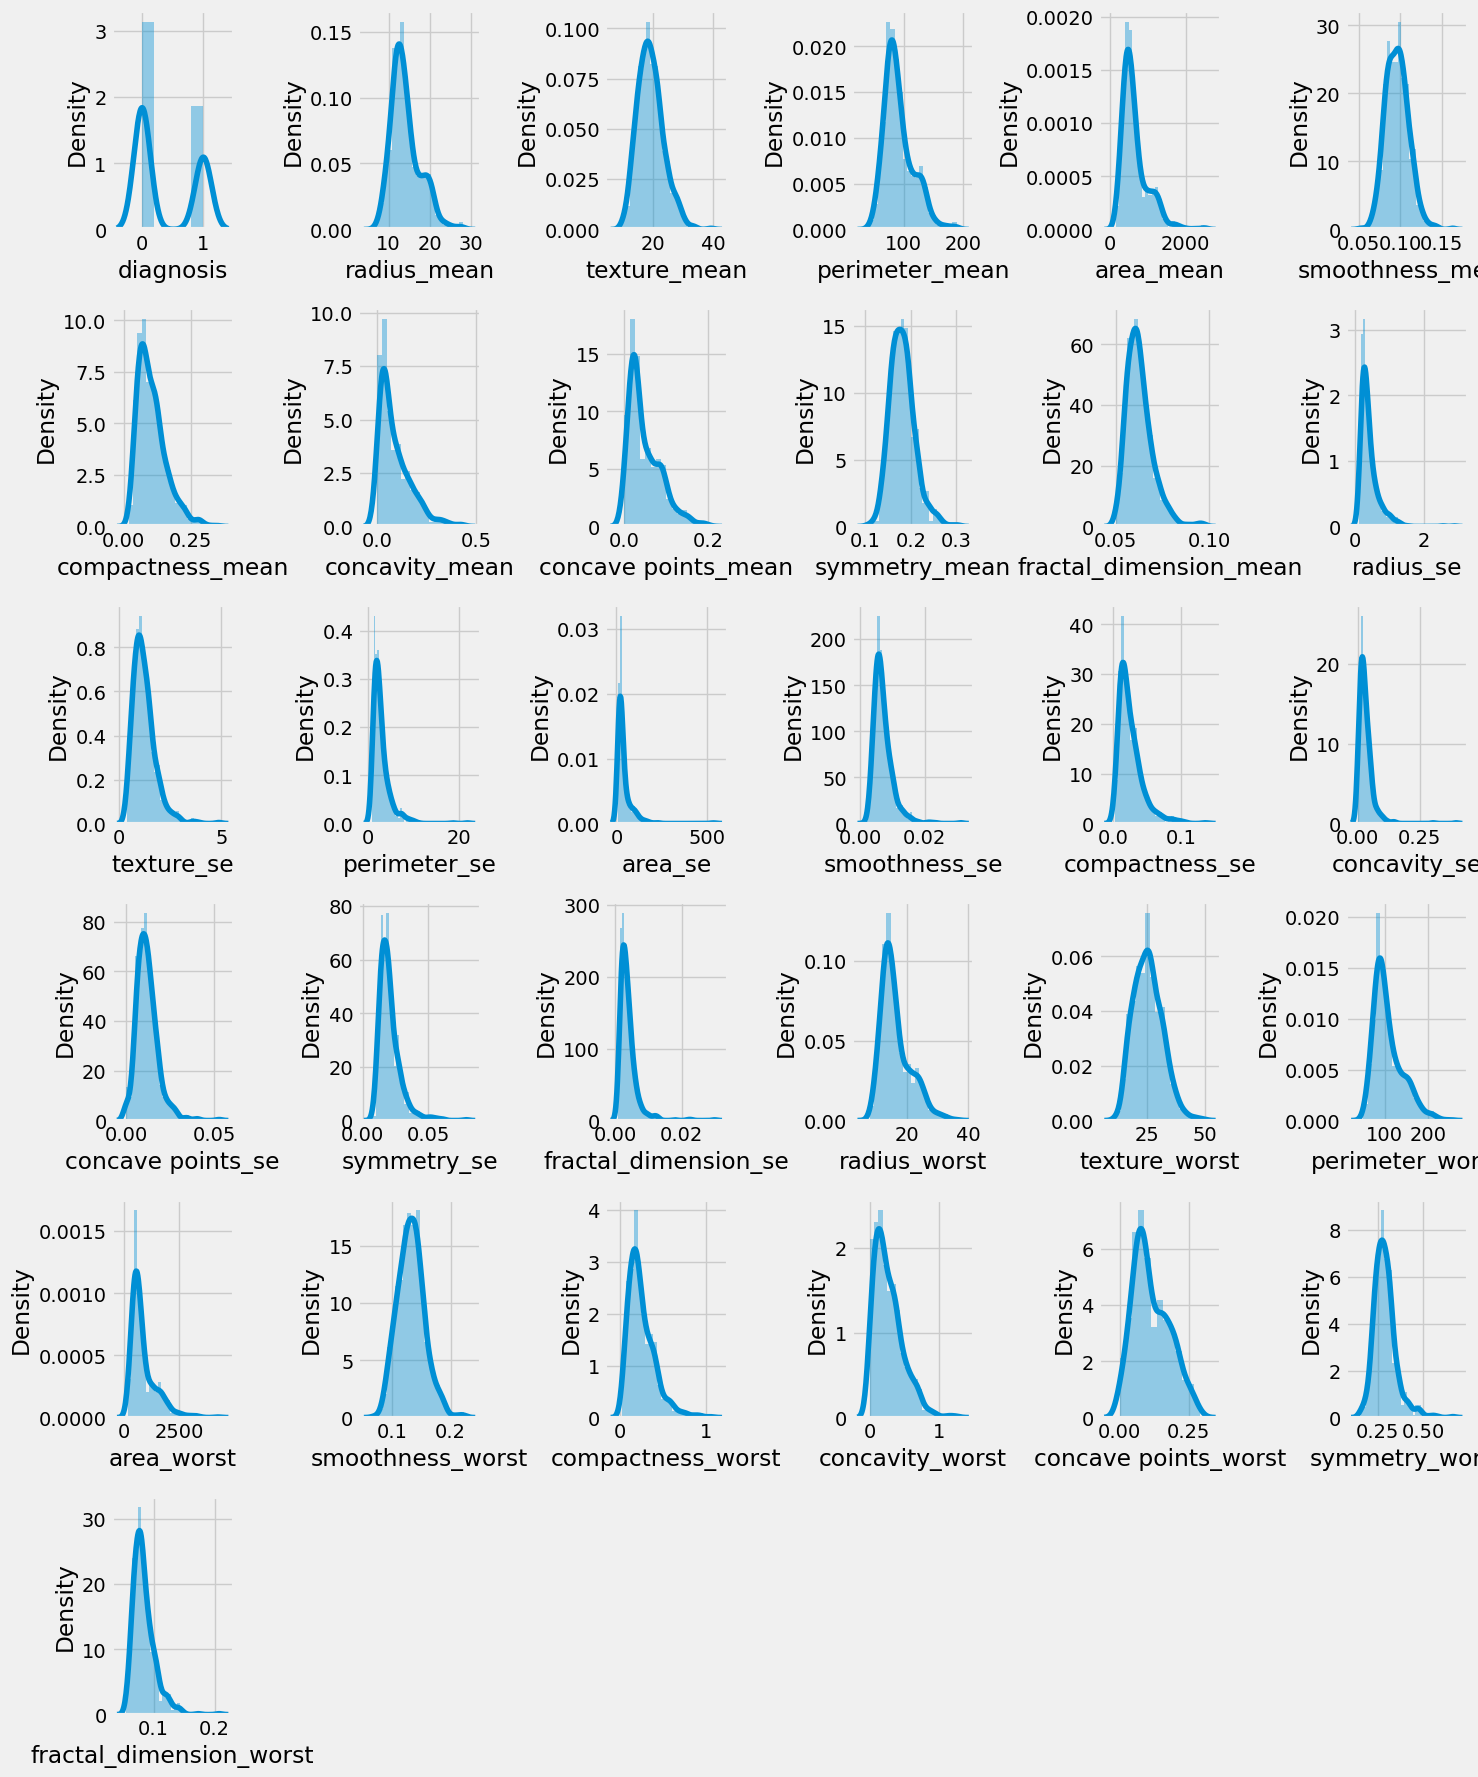

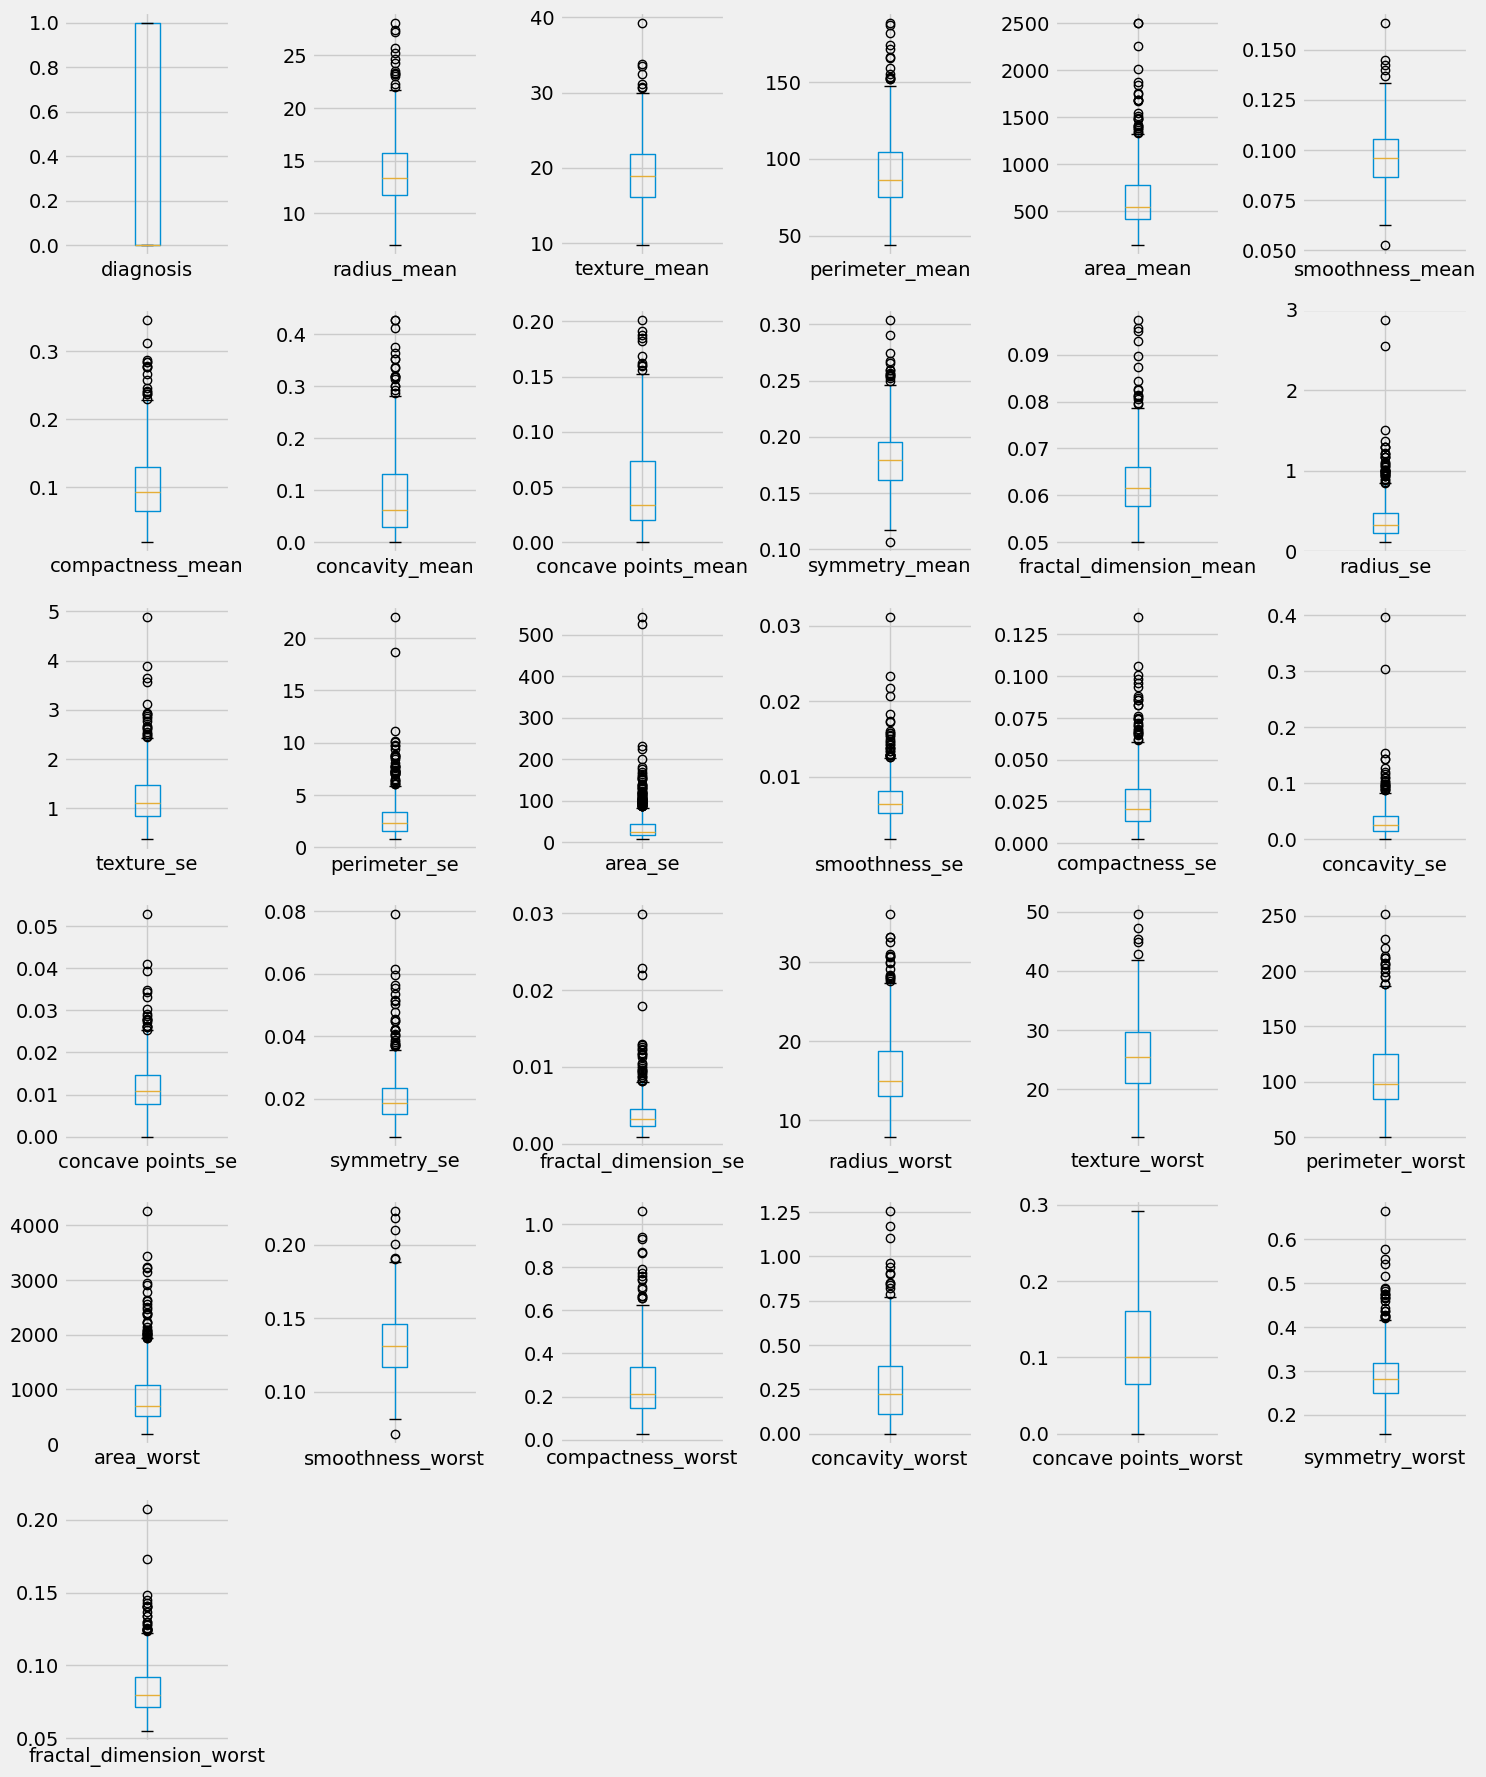

In [239]:
#Understanding the feature set
import math
print('\033[1mFeatures Distribution'.center(100))

n=6
nf = [i for i in data.columns.to_list()]

plt.figure(figsize=[15,3*math.ceil(len(nf)/n)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/n),n,c+1)
    sns.distplot(data[nf[c]])
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,3*math.ceil(len(nf)/n)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/n),n,c+1)
    data.boxplot(nf[c])
plt.tight_layout()
plt.show()

In [240]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from tabulate import tabulate
from tqdm import tqdm

In [241]:
def BasedModel():
    basedModels = []
    basedModels.append(('LR'   , LogisticRegression()))
    basedModels.append(('LDA'  , LinearDiscriminantAnalysis()))
    basedModels.append(('RF'   , RandomForestClassifier()))
    basedModels.append(('NB'   , GaussianNB()))
    basedModels.append(('AB'   , AdaBoostClassifier()))
    basedModels.append(('GBM'  , GradientBoostingClassifier()))
    basedModels.append(('ET'   , ExtraTreesClassifier()))
    basedModels.append(('XG'   , XGBClassifier()))
    basedModels.append(('LG'   , LGBMClassifier()))
    basedModels.append(('CAT'   , CatBoostClassifier(silent=True)))
    return basedModels

In [242]:
def BasedLine(df, models, n_splits=10):
    start_time = time.time()  # Record the start time
    
    df_check = df.copy()
    
    y = df_check['diagnosis']
    X = df_check.drop(columns='diagnosis')

    # Define the cross-validation strategy (Stratified K-Fold)
    stratified_kfold = StratifiedKFold(n_splits=n_splits, random_state=2023, shuffle=True)

    # Test options and evaluation metric
    scoring = 'accuracy'
    results, results_weigh = [], []
    names = []
    scores, scores_weigh = [], []
    data = []
    for name, model in models:
        # Initialize lists to store individual model scores
        model_scores = []
        model_scores_weigh = []
        
        with tqdm(total=n_splits, desc=f"Running {name}") as pbar:
            for train_idx, test_idx in stratified_kfold.split(X, y):
                X_train, X_valid = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_valid = y.iloc[train_idx], y.iloc[test_idx]
                
                model.fit(X_train, y_train)
                score_non = accuracy_score(model.predict(X_valid), y_valid)
                score_weigh = f1_score(model.predict(X_valid), y_valid, average='weighted')
                model_scores.append(score_non)
                model_scores_weigh.append(score_weigh)
                pbar.update(1)

        names.append(name)
        scores_weigh.append(model_scores_weigh)
        
        data.append([name, np.mean(model_scores), np.mean(model_scores_weigh)])
    
    print(tabulate(data, headers=["Model", "Accuracy", "F1 Score Weighted"], tablefmt='orgtbl'))
    
    end_time = time.time()  # Record the end time
    execution_time = end_time - start_time
    print("Execution time: {:.2f} seconds".format(execution_time))
    
    df_results = pd.DataFrame(data, columns=["Model", "Accuracy", "F1 Score Weighted"])
    return df_results


In [243]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [86]:
models = BasedModel()

In [87]:
#result 
result = BasedLine(df = data, models = models, n_splits=10)

Running CAT: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [02:05<00:00, 12.56s/it]

| Model   |   Accuracy |   F1 Score Weighted |
|---------+------------+---------------------|
| LR      |   0.947243 |            0.947611 |
| LDA     |   0.956046 |            0.956973 |
| RF      |   0.961247 |            0.961493 |
| NB      |   0.936623 |            0.93695  |
| AB      |   0.971805 |            0.972137 |
| GBM     |   0.96297  |            0.963332 |
| ET      |   0.959492 |            0.959773 |
| XG      |   0.961278 |            0.961402 |
| LG      |   0.966447 |            0.967122 |
| CAT     |   0.97005  |            0.970315 |
Execution time: 153.48 seconds


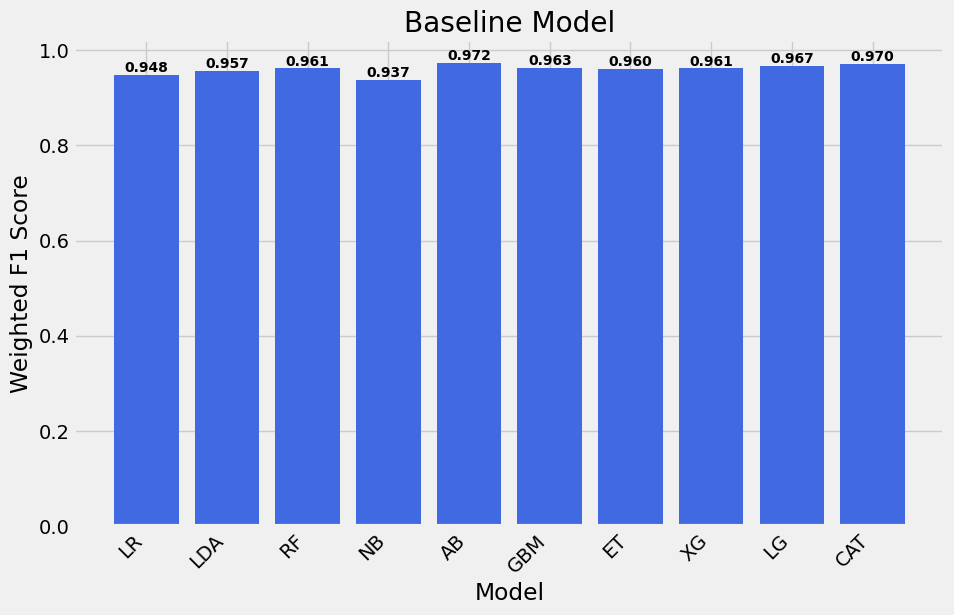

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(result.Model, result["F1 Score Weighted"], color='royalblue')
plt.xlabel('Model')
plt.ylabel('Weighted F1 Score')
plt.title('Baseline Model')
plt.xticks(rotation=45, ha="right")

# Display the values on top of the bars
for i, v in enumerate(result["F1 Score Weighted"]):
    plt.text(i, v, f"{v:.3f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.savefig('baselinemodel.png')

In [118]:
import optuna

In [119]:
def rm(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))    
    for col in df.columns:
        col_type = df[col].dtype        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [120]:
optimized_data = rm(df = data)

Memory usage of dataframe is 0.13 MB
Memory usage after optimization is: 0.03 MB
Decreased by 74.9%


In [122]:
target_data = optimized_data.diagnosis
train_data = optimized_data.drop("diagnosis", axis = "columns")

In [123]:
def objective(trial , X = train_data, y = target_data):
    train_x , test_x , train_y , test_y = train_test_split(X , y , test_size = 0.2 , random_state = 42, stratify = y)    
    params = {
        'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
        'C' : trial.suggest_loguniform("C", 1e-2, 1),
       'fit_intercept' : trial.suggest_categorical('fit_intercept' , [True, False]),
       'solver' : trial.suggest_categorical('solver' , ['lbfgs','liblinear']),
        "n_jobs" : -1
    }
    model1 = LogisticRegression(**params, random_state = 2020)
    model1.fit(train_x , train_y)
    y_predlr = model1.predict(test_x)
    ll = f1_score(test_y , y_predlr, average="weighted")
    return ll

In [124]:
optuna.logging.set_verbosity(optuna.logging.WARNING) # i do not want to see trail information
study = optuna.create_study(direction = 'minimize' , study_name = 'lr', pruner = optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials = 50)
print('numbers of the finished trials:' , len(study.trials))
print('the best params:' , study.best_trial.params)
print('the best value:' , study.best_value)

numbers of the finished trials: 50
the best params: {'tol': 0.0005587589057149886, 'C': 0.01084340045059846, 'fit_intercept': True, 'solver': 'liblinear'}
the best value: 0.9005572755417958


In [179]:
def get_best_param(optuna_study):
    num = optuna_study.trials_dataframe()['value'].tolist() 
    ind = num.index(max(num))
    print(optuna_study.trials[ind].params)

In [180]:
get_best_param(optuna_study = study)

{'tol': 0.0009628137202887322, 'C': 0.6699706356052199, 'fit_intercept': True, 'solver': 'lbfgs'}


In [125]:
def objective_rfc(trial, X=train_data, y=target_data):
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    params = {
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.01, 0.5),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.01, 0.5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'n_jobs': -1,
        'random_state': 2020
    }
    
    model = RandomForestClassifier(**params, n_estimators = 1500)
    model.fit(train_x, train_y)
    y_pred_rf = model.predict(test_x)
    f1_weighted = f1_score(test_y, y_pred_rf, average='weighted')
    return f1_weighted

In [126]:
optuna.logging.set_verbosity(optuna.logging.WARNING) # i do not want to see trail information
study_rfc = optuna.create_study(direction = 'minimize' , study_name = 'rfc', pruner = optuna.pruners.HyperbandPruner())
study_rfc.optimize(objective_rfc, n_trials = 50)
print('numbers of the finished trials:' , len(study_rfc.trials))
print('the best params:' , study_rfc.best_trial.params)
print('the best value:' , study_rfc.best_value)

numbers of the finished trials: 50
the best params: {'max_depth': 19, 'min_samples_split': 0.44989502325201447, 'min_samples_leaf': 0.4411470519580534, 'max_features': 'sqrt'}
the best value: 0.48896434634974534


In [181]:
get_best_param(optuna_study = study_rfc)

{'max_depth': 24, 'min_samples_split': 0.4955864822235674, 'min_samples_leaf': 0.2904449437822276, 'max_features': 'log2'}


In [127]:
    
def objective_gbt(trial, X=train_data, y=target_data):
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.01, 0.5),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.01, 0.5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'random_state': 2020
    }
    
    model = GradientBoostingClassifier(**params, n_estimators=1500)
    model.fit(train_x, train_y)
    y_pred_rf = model.predict(test_x)
    f1_weighted = f1_score(test_y, y_pred_rf, average='weighted')
    return f1_weighted

In [128]:
optuna.logging.set_verbosity(optuna.logging.WARNING) # i do not want to see trail information
study_gbt = optuna.create_study(direction = 'minimize' , study_name = 'rfc', pruner = optuna.pruners.HyperbandPruner())
study_gbt.optimize(objective_gbt, n_trials = 50)
print('numbers of the finished trials:' , len(study_gbt.trials))
print('the best params:' , study_gbt.best_trial.params)
print('the best value:' , study_gbt.best_value)

numbers of the finished trials: 50
the best params: {'learning_rate': 0.05517008338525693, 'max_depth': 6, 'min_samples_split': 0.1174382618491897, 'min_samples_leaf': 0.33690692763749736, 'max_features': 'log2', 'subsample': 0.6471292645349693}
the best value: 0.48896434634974534


In [182]:
get_best_param(optuna_study = study_gbt)

{'learning_rate': 0.027862741443502145, 'max_depth': 6, 'min_samples_split': 0.4406862647333402, 'min_samples_leaf': 0.307800402782145, 'max_features': 'sqrt', 'subsample': 0.6270366700304478}


In [129]:
def objective_gb(trial, X=train_data, y=target_data):
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
    'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_jobs': -1,
        'random_state': 2020
    }
    
    model = XGBClassifier(**params)
    model.fit(train_x, train_y)
    y_pred_xgb = model.predict(test_x)
    f1_weighted = f1_score(test_y, y_pred_xgb, average='weighted')
    return f1_weighted

In [130]:
optuna.logging.set_verbosity(optuna.logging.WARNING) # i do not want to see trail information
study_gb = optuna.create_study(direction = 'minimize' , study_name = 'rfc', pruner = optuna.pruners.HyperbandPruner())
study_gb.optimize(objective_gb, n_trials = 50)
print('numbers of the finished trials:' , len(study_gbt.trials))
print('the best params:' , study_gb.best_trial.params)
print('the best value:' , study_gb.best_value)

numbers of the finished trials: 50
the best params: {'learning_rate': 0.040613452249059996, 'max_depth': 3, 'min_child_weight': 2.011959583242141, 'gamma': 0.46023293510067287}
the best value: 0.9554882874504246


In [183]:
get_best_param(optuna_study = study_gb)

{'learning_rate': 0.061681980574865534, 'max_depth': 5, 'min_child_weight': 5.084250525660471, 'gamma': 0.43963787822790934}


In [131]:
def objective_lgb(trial, X=train_data, y=target_data):
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 31, 1023),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 5),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-9, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-9, 10.0),
        'n_jobs': -1,
        'random_state': 2020
    }
    
    model = LGBMClassifier(**params, n_estimators=1500)
    model.fit(train_x, train_y)
    y_pred_lgbm = model.predict(test_x)
    f1_weighted = f1_score(test_y, y_pred_lgbm, average='weighted')
    return f1_weighted

In [132]:
optuna.logging.set_verbosity(optuna.logging.WARNING) # i do not want to see trail information
study_lgb = optuna.create_study(direction = 'minimize' , study_name = 'lgb', pruner = optuna.pruners.HyperbandPruner())
study_lgb.optimize(objective_lgb, n_trials = 50)
print('numbers of the finished trials:' , len(study_lgb.trials))
print('the best params:' , study_lgb.best_trial.params)
print('the best value:' , study_lgb.best_value)

numbers of the finished trials: 50
the best params: {'learning_rate': 0.0101687071058835, 'max_depth': 6, 'num_leaves': 249, 'min_child_samples': 4, 'subsample': 0.8752383153677136, 'colsample_bytree': 0.7202629844165922, 'subsample_freq': 2, 'reg_alpha': 0.0009571915856017457, 'reg_lambda': 0.04979014755542851}
the best value: 0.9645092460881936


In [133]:
def objective_cat(trial, X=train_data, y=target_data):
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10.0),
        'random_state': 2020,
        'silent': True 
    }
    
    model = CatBoostClassifier(**params, n_estimators = 1500)
    model.fit(train_x, train_y)
    y_pred_catboost = model.predict(test_x)
    f1_weighted = f1_score(test_y, y_pred_catboost, average='weighted')
    return f1_weighted

In [134]:
def print_trials(study, trial):
    print(f"Trial {trial.number} - Value: {trial.value:.6f}")
    if trial.state == optuna.trial.TrialState.FAIL:
        print(f"Trial {trial.number} failed.")

In [135]:
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Set the verbosity to a minimum level
study_cat = optuna.create_study(direction='minimize',study_name='cat',pruner=optuna.pruners.HyperbandPruner())
study_cat.optimize(objective_cat, n_trials=50, callbacks=[print_trials])

print('Numbers of the finished trials:', len(study_cat.trials))
print('The best params:', study_cat.best_trial.params)
print('The best value:', study_cat.best_value)

Trial 0 - Value: 0.973465
Trial 1 - Value: 0.973465
Trial 2 - Value: 0.964509
Trial 3 - Value: 0.973465
Trial 4 - Value: 0.973465
Trial 5 - Value: 0.964509
Trial 6 - Value: 0.964509
Trial 7 - Value: 0.973465
Trial 8 - Value: 0.973465
Trial 9 - Value: 0.973465
Trial 10 - Value: 0.973465
Trial 11 - Value: 0.964509
Trial 12 - Value: 0.973465
Trial 13 - Value: 0.973465
Trial 14 - Value: 0.973465
Trial 15 - Value: 0.964509
Trial 16 - Value: 0.973465
Trial 17 - Value: 0.973465
Trial 18 - Value: 0.973465
Trial 21 - Value: 0.964509
Trial 22 - Value: 0.973465
Trial 23 - Value: 0.973465
Trial 24 - Value: 0.973465
Trial 25 - Value: 0.973465
Trial 26 - Value: 0.973465
Trial 27 - Value: 0.964509
Trial 28 - Value: 0.964509
Trial 29 - Value: 0.973465
Trial 30 - Value: 0.955488
Trial 31 - Value: 0.973465
Trial 32 - Value: 0.973465
Trial 33 - Value: 0.964509
Trial 34 - Value: 0.955488
Trial 35 - Value: 0.964509
Trial 36 - Value: 0.973465
Trial 37 - Value: 0.964509
Trial 38 - Value: 0.955488
Trial 39 - 

In [184]:
get_best_param(optuna_study = study_cat)

{'max_depth': 4, 'min_child_samples': 1, 'colsample_bylevel': 0.8078202298727539, 'subsample': 0.7894132002590863, 'l2_leaf_reg': 3.2841273334065156e-08}


In [136]:
def objective_EXT(trial, X=train_data, y=target_data):
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    params = {
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.01, 0.5),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.01, 0.5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'n_jobs': -1,
        'random_state': 2020
    }
    
    model = ExtraTreesClassifier(**params, n_estimators = 1500)
    model.fit(train_x, train_y)
    y_pred_et = model.predict(test_x)
    f1_weighted = f1_score(test_y, y_pred_et, average='weighted')
    return f1_weighted

In [137]:
optuna.logging.set_verbosity(optuna.logging.WARNING) # i do not want to see trail information
study_ext = optuna.create_study(direction = 'minimize' , study_name = 'ext', pruner = optuna.pruners.HyperbandPruner())
study_ext.optimize(objective_EXT, n_trials = 50)
print('numbers of the finished trials:' , len(study_ext.trials))
print('the best params:' , study_ext.best_trial.params)
print('the best value:' , study_ext.best_value)

numbers of the finished trials: 50
the best params: {'max_depth': 28, 'min_samples_split': 0.21748392530017127, 'min_samples_leaf': 0.44984194760479773, 'max_features': 'sqrt'}
the best value: 0.48896434634974534


In [185]:
get_best_param(optuna_study = study_ext)

{'max_depth': 11, 'min_samples_split': 0.13437125791762375, 'min_samples_leaf': 0.039024546816448465, 'max_features': 'sqrt'}


In [186]:
log_param = {'tol': 0.0009628137202887322, 'C': 0.6699706356052199, 'fit_intercept': True, 'solver': 'lbfgs'}
rfc_param = {'max_depth': 24, 'min_samples_split': 0.4955864822235674, 'min_samples_leaf': 0.2904449437822276, 'max_features': 'log2'}
xg_param = {'learning_rate': 0.061681980574865534, 'max_depth': 5, 'min_child_weight': 5.084250525660471, 'gamma': 0.43963787822790934}
ext_param = {'max_depth': 11, 'min_samples_split': 0.13437125791762375, 'min_samples_leaf': 0.039024546816448465, 'max_features': 'sqrt'}
gbt_param =  {'learning_rate': 0.027862741443502145, 'max_depth': 6, 'min_samples_split': 0.4406862647333402, 'min_samples_leaf': 0.307800402782145, 'max_features': 'sqrt', 'subsample': 0.6270366700304478}
lg_param = {'learning_rate': 0.0101687071058835, 'max_depth': 6, 'num_leaves': 249, 'min_child_samples': 4, 'subsample': 0.8752383153677136, 'colsample_bytree': 0.7202629844165922, 'subsample_freq': 2, 'reg_alpha': 0.0009571915856017457, 'reg_lambda': 0.04979014755542851}
cat_param = {'max_depth': 4, 'min_child_samples': 1, 'colsample_bylevel': 0.8078202298727539, 'subsample': 0.7894132002590863, 'l2_leaf_reg': 3.2841273334065156e-08}

In [244]:
def OptimizedModel():
    optimizedModels = []
    optimizedModels.append(('LR'   , LogisticRegression(**log_param)))
    optimizedModels.append(('RF'   , RandomForestClassifier(**rfc_param, n_estimators = 1500)))
    optimizedModels.append(('GBM'  , GradientBoostingClassifier(**gbt_param, n_estimators = 1500)))
    optimizedModels.append(('ET'   , ExtraTreesClassifier(**ext_param, n_estimators = 1500)))
    optimizedModels.append(('XG'   , XGBClassifier(**xg_param, n_estimators = 1500)))
    optimizedModels.append(('LG'   , LGBMClassifier(**lg_param, n_estimators = 1500)))
    optimizedModels.append(('CAT'   , CatBoostClassifier(**cat_param, n_estimators = 1500, silent=True)))
    return optimizedModels

In [245]:
#result 
optimized_result = BasedLine(df = data, models = OptimizedModel(), n_splits=10)

Running CAT: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [09:29<00:00, 56.90s/it]

| Model   |   Accuracy |   F1 Score Weighted |
|---------+------------+---------------------|
| LR      |   0.945489 |            0.945937 |
| RF      |   0.911999 |            0.911427 |
| GBM     |   0.936748 |            0.936721 |
| ET      |   0.945457 |            0.946252 |
| XG      |   0.961278 |            0.96146  |
| LG      |   0.96651  |            0.966776 |
| CAT     |   0.96651  |            0.967002 |
Execution time: 761.20 seconds


In [246]:
optimized_result

Model  Accuracy  F1 Score Weighted
0    LR  0.945489           0.945937
1    RF  0.911999           0.911427
2   GBM  0.936748           0.936721
3    ET  0.945457           0.946252
4    XG  0.961278           0.961460
5    LG  0.966510           0.966776
6   CAT  0.966510           0.967002

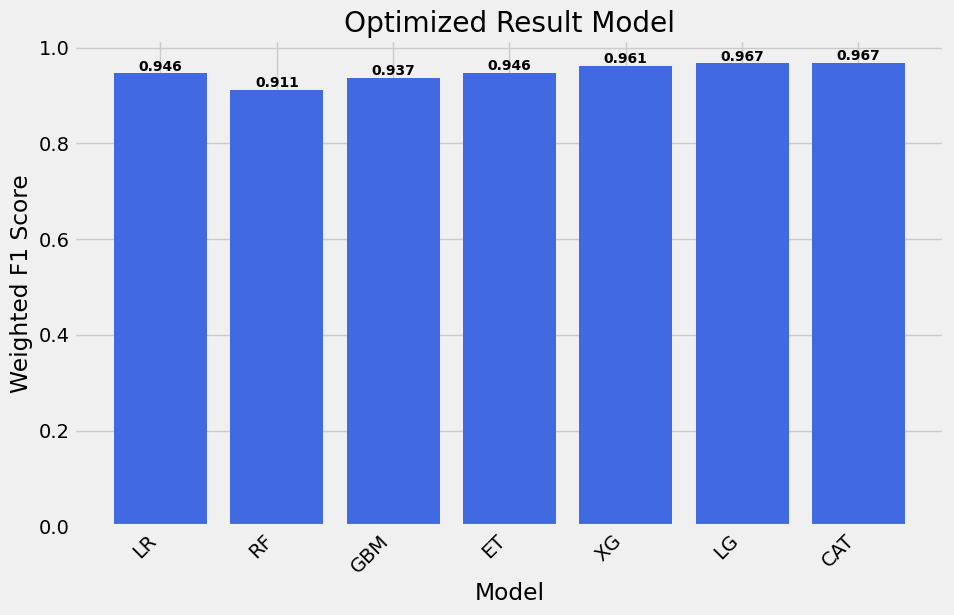

In [247]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(optimized_result.Model, optimized_result["F1 Score Weighted"], color='royalblue')
plt.xlabel('Model')
plt.ylabel('Weighted F1 Score')
plt.title('Optimized Result Model')
plt.xticks(rotation=45, ha="right")

# Display the values on top of the bars
for i, v in enumerate(optimized_result["F1 Score Weighted"]):
    plt.text(i, v, f"{v:.3f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.savefig('optimized_result_bar.png')

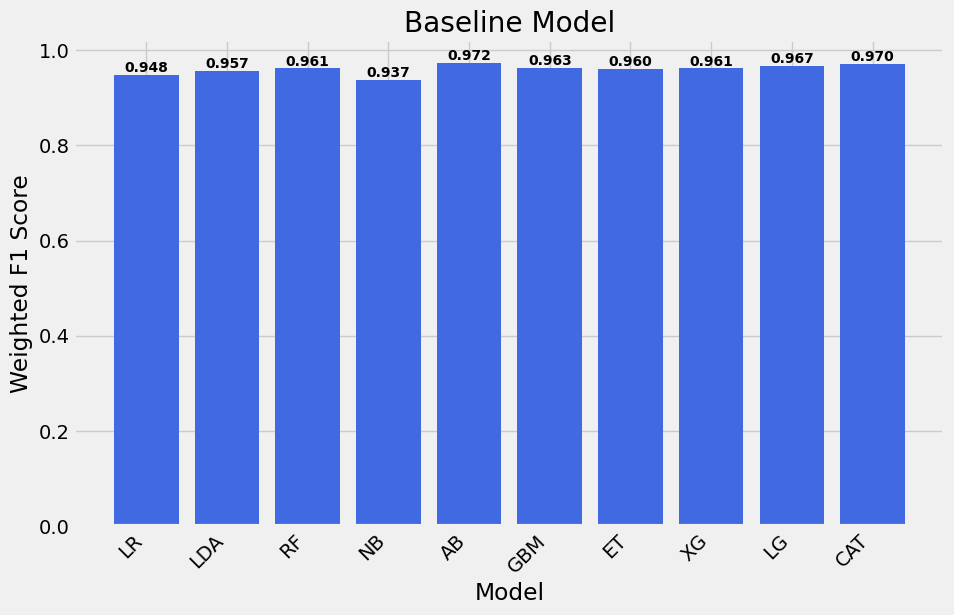

In [248]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(result.Model, result["F1 Score Weighted"], color='royalblue')
plt.xlabel('Model')
plt.ylabel('Weighted F1 Score')
plt.title('Baseline Model')
plt.xticks(rotation=45, ha="right")

# Display the values on top of the bars
for i, v in enumerate(result["F1 Score Weighted"]):
    plt.text(i, v, f"{v:.3f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.savefig('baselinemodel.png')

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(train_data, target_data, test_size=0.2, random_state=42, stratify=target_data)

In [ ]:
model = LGBMClassifier(**lg_param)


# Fits the model on the data
model.fit(train_x, train_y)

LGBMClassifier(colsample_bytree=0.7202629844165922,
               learning_rate=0.0101687071058835, max_depth=6,
               min_child_samples=4, num_leaves=249,
               reg_alpha=0.0009571915856017457, reg_lambda=0.04979014755542851,
               subsample=0.8752383153677136, subsample_freq=2)

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_x)

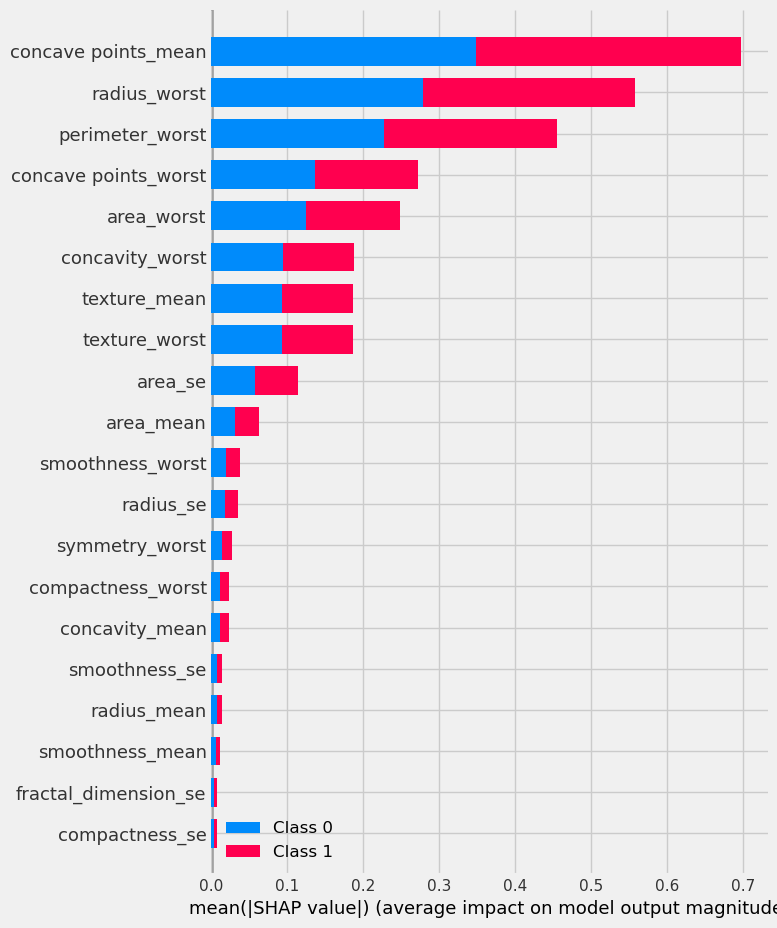

In [ ]:
shap.summary_plot(shap_values, test_x)

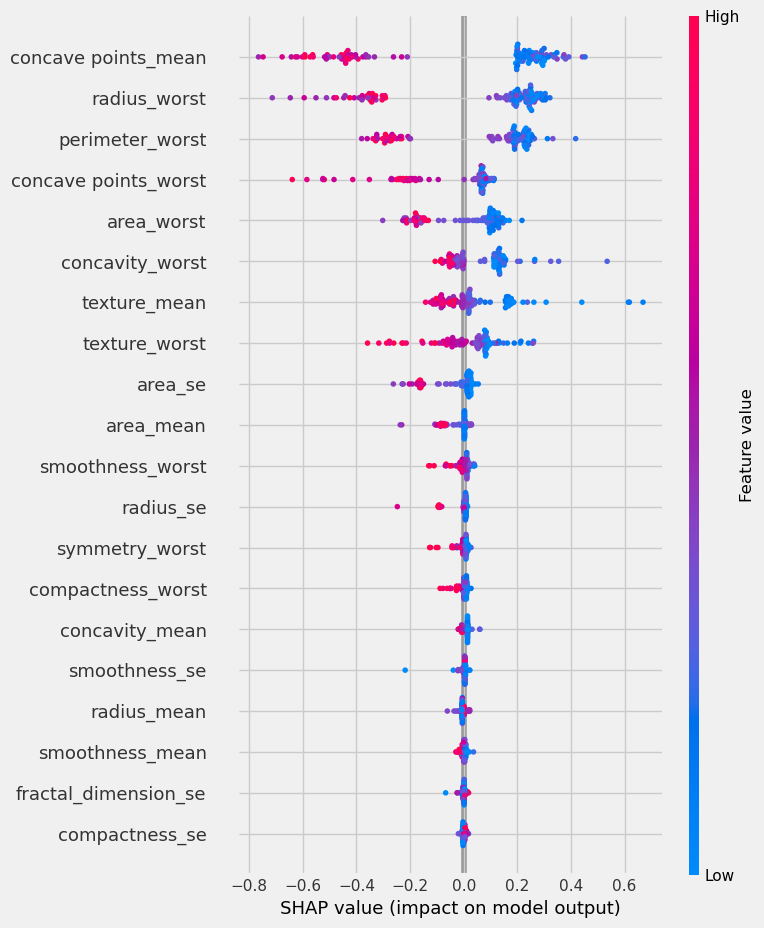

In [ ]:
shap.summary_plot(shap_values[0], test_x)

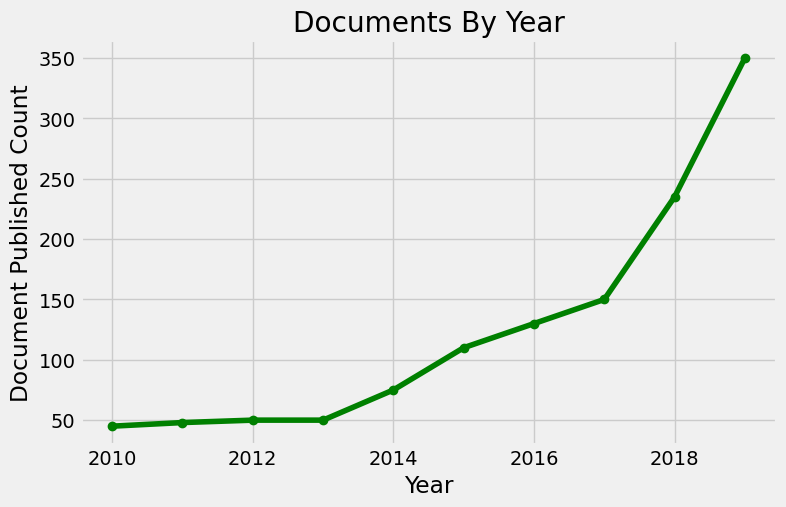

In [ ]:
import matplotlib.pyplot as plt

data = [45, 48, 50, 50, 75, 110, 130, 150, 235, 350]
years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

# Create a line graph
plt.figure(figsize=(8, 5))
plt.plot(years, data, marker='o', linestyle='-', color='green')  # Use marker 'o' for data points
plt.title('Documents By Year')
plt.xlabel('Year')
plt.ylabel('Document Published Count')
plt.grid(True)
plt.savefig('corpusdata.png')